# Test the mlflow in aws

In [1]:
!pip install mlflow
import mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.0/677.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 18.3 MB/s eta 0:00:00


In [2]:
mlflow.set_tracking_uri("http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/")
with mlflow.start_run():
    mlflow.log_param("param1",15)
    mlflow.log_param("metric1",0.89)

🏃 View run debonair-ram-970 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/0/runs/517f185569954813a0f696eaecc0360e
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/0


# DATA Collection and Preprocess

In [3]:
import numpy as np
import pandas as pd

In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df=df[~(df['clean_comment'].str.strip()=='')]

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
def preprocess_comments(comment):
    comment=comment.lower()
    comment=comment.strip()
    comment=re.sub(r'\n',' ',comment)
    comment=re.sub(r'[^A-Za-z0-9\s!?.,]','',comment)

    stop_words=set(stopwords.words('english'))-{'not','but','however','yet','no'}
    comment=' '.join([word for word in comment.split() if word  not in stop_words])

    lemmatizer=WordNetLemmatizer()
    comment=' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [9]:
df['clean_comment']=df['clean_comment'].apply(preprocess_comments)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


# Model Building

In [10]:
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_predict
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [12]:
vectorizer=CountVectorizer(max_features=10000)
X=vectorizer.fit_transform(df['clean_comment']).toarray()
y=df['category']

In [13]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
y

,category
0,1
1,1
2,-1
3,0
4,1
...,...
37244,0
37245,1
37246,0
37247,1


In [15]:
print(X.shape)
print(y.shape)

(36793, 10000)
(36793,)


In [17]:
mlflow.set_tracking_uri('http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/')
mlflow.set_experiment('Random Forest BaselineModel')

2025/07/26 09:58:31 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest BaselineModel' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-26072025/163317569003760097', creation_time=1753523911496, experiment_id='163317569003760097', last_update_time=1753523911496, lifecycle_stage='active', name='Random Forest BaselineModel', tags={}>

In [18]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 8.8 MB/s eta 0:00:00


In [19]:
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 43.2 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [ ]:
!aws configure

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

2025/07/26 10:01:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 10:01:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/163317569003760097/runs/0cf71f10663944cc88951f698d51e4c9
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/163317569003760097
Accuracy:0.6479141187661367


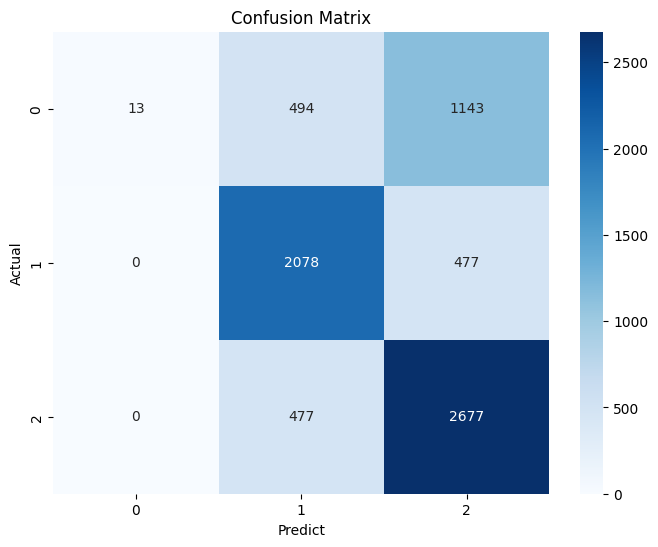

In [22]:
with mlflow.start_run():
  mlflow.set_tag(key='mlflow.runName',value='RandomForest_Baseline_TrainTestSplit')
  mlflow.set_tag(key='experiment_type',value='baseline')
  mlflow.set_tag('model_type','RandomForestClassifier')
  mlflow.set_tag('description',"Baseline RandomForest model for sentiment analysis using Bag of Words with train test split")

  mlflow.log_param("vectorizer_type","CountVectorizer")
  mlflow.log_param("vectorizer_max_features",vectorizer.max_features)

  n_estimators=200
  max_depth=15

  mlflow.log_param("n_estimators",n_estimators)
  mlflow.log_param("max_depth",max_depth)

  model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42)
  model.fit(X_train,y_train)

  y_pred=model.predict(X_test)

  accuracy=accuracy_score(y_test,y_pred)
  mlflow.log_metric("accuracy",accuracy)

  classification_report=classification_report(y_test,y_pred,output_dict=True)
  for label,metrics in classification_report.items():
    if isinstance(metrics,dict):
      for metric,value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}",value)

  confusion_matrix=confusion_matrix(y_test,y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(confusion_matrix,annot=True,fmt='d',cmap='Blues')
  plt.xlabel('Predict')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.savefig('confusion_matrix.png')
  mlflow.log_artifact('/content/confusion_matrix.png')

  mlflow.sklearn.log_model(model,'random_forest_model')

  df.to_csv('dataset.csv',index=False)
  mlflow.log_artifact('/content/dataset.csv')

print(f"Accuracy:{accuracy}")


In [23]:
df.to_csv('reddit_preprocessing.csv', index=False)